# This notebook is slow to run
## this is because the top level function can't be decorated for reproducibility: tf.random.set_seed doesn't do anything when inside a graph.

In [1]:
import gc
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pykalman
import seaborn

import tensorflow as tf
import tensorflow_probability as tfp
import tqdm

# tf.function = lambda x: x
tfd = tfp.distributions

seaborn.set()
tf.random.set_seed(66)
np.random.seed(42)

In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform, PartiallyCorrectedRegularizedTransform
from filterflow.resampling.differentiable.sliced import SVDSlicedTransform
from filterflow.resampling.differentiable.optimized import OptimizedPointCloud
from filterflow.resampling.differentiable.optimizer.sgd import SGD
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver
from filterflow.resampling.differentiable.loss.sliced_wasserstein.swd import SlicedWassersteinDistance
from filterflow.resampling.differentiable.loss.regularized import SinkhornLoss
from filterflow.resampling.differentiable.loss.sliced_wasserstein.utils import sqeuclidean, norm_1

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Set the State Space Model

In [4]:

observation_dim = 2
state_dim = 2
T = 150
initial_state          = tf.random.uniform([state_dim], -1., 1.)

transition_matrix      = tf.eye(state_dim) * 0.5
transition_covariance  = tf.eye(state_dim) * 0.5

chol_transition_covariance = tf.linalg.cholesky(transition_covariance)

observation_matrix     = tf.eye(observation_dim)
observation_covariance = tf.eye(observation_dim) * 0.1

chol_observation_covariance = tf.linalg.cholesky(observation_covariance)

In [5]:
# Transition
zeros = tf.zeros(state_dim, dtype=float)

transition_noise = tfd.MultivariateNormalTriL(zeros, chol_transition_covariance)
transition_model = RandomWalkModel(transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(zeros, chol_observation_covariance)
observation_model = LinearObservationSampler(observation_matrix, observation_error)

In [6]:
kf = pykalman.KalmanFilter(transition_matrix.numpy(), 
                           observation_matrix.numpy(), 
                           transition_covariance.numpy(), 
                           observation_covariance.numpy())

In [7]:
states, obs = kf.sample(T, initial_state.numpy())

In [8]:
np_obs = np.asanyarray(obs.data, dtype=np.float32)
np_states = np.asanyarray(states.data, dtype=np.float32)


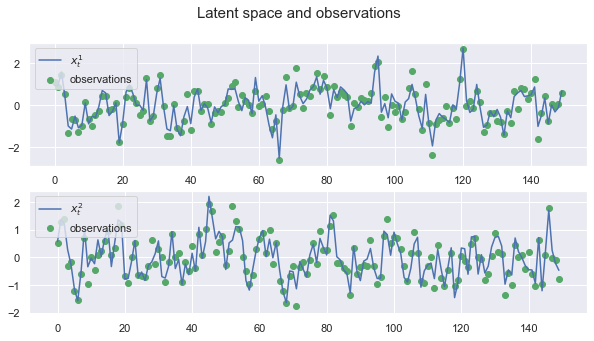

In [9]:
linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [10]:
obs_data = tf.data.Dataset.from_tensor_slices(np_obs)

### Set up the filter

In [11]:
# store observations
batch_size = 1
n_particles = 25
dimension = 2

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods, 
                      ancestor_indices=None, 
                      resampling_correction=None)


modifiable_transition_matrix = tf.Variable(tf.linalg.diag([0., 0.]))
modifiable_transition_model = RandomWalkModel(modifiable_transition_matrix, transition_noise)
modifiable_proposal_model = BootstrapProposalModel(modifiable_transition_model)


In [12]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
multinomial = MultinomialResampler()

epsilon = tf.constant(0.5)
scaling = tf.constant(0.75)
convergence_threshold=tf.constant(1e-2)
max_iter=tf.constant(500)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold)


solver = PetkovSolver(tf.constant(50))

corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=tf.constant(False))
propagated_corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=tf.constant(True))
partially_corrected = PartiallyCorrectedRegularizedTransform(regularized)

learning_rate, n_epochs, decay = tf.constant(0.1), tf.constant(50), tf.constant(0.95)

sinkhorn_loss = SinkhornLoss(epsilon, symmetric=True, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold)
sinkhorn_optimizer = SGD(sinkhorn_loss, learning_rate, n_epochs, decay)
sinkhorn_optimized_cloud = OptimizedPointCloud(sinkhorn_optimizer, regularized)

svd_sliced_resampler = SVDSlicedTransform(1)
partially_corrected_svd = PartiallyCorrectedRegularizedTransform(svd_sliced_resampler)


sliced_loss = SlicedWassersteinDistance(tf.constant(10), norm_1)
sliced_optimizer = SGD(sliced_loss, learning_rate, n_epochs, decay)
sliced_optimized_cloud = OptimizedPointCloud(sliced_optimizer, regularized)

multinomial_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, multinomial)
regularized_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, regularized)
corrected_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, corrected)
propagated_corrected_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, propagated_corrected)
partially_corrected_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, partially_corrected)
sinkhorn_optimized_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, sinkhorn_optimized_cloud)
sliced_optimized_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, sliced_optimized_cloud)
svd_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, svd_sliced_resampler)
partially_corrected_svd_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, partially_corrected_svd)




In [13]:
mesh_size = 20
x_linspace = np.linspace(0.1, 0.7, mesh_size).astype(np.float32)
y_linspace = np.linspace(0.2, 0.8, mesh_size).astype(np.float32)
mesh = np.asanyarray([(x, y) for x in x_linspace for y in y_linspace])

In [14]:
@tf.function
def get_res(smc, use_correction_term):
    with tf.GradientTape() as tape:
        tape.watch(modifiable_transition_matrix)
        final_state = smc(initial_state, observation_series=obs_data, n_observations=T, return_final=True)
        ll = tf.reduce_mean(final_state.log_likelihoods, keepdims=True)
        if use_correction_term:
            correction_term = final_state.resampling_correction
            corrected_ll = ll + correction_term
        else:
            corrected_ll = ll
    ll_grad = tf.linalg.diag_part(tape.gradient(corrected_ll, modifiable_transition_matrix))
    return ll, ll_grad

In [15]:
# do not decorate this function - tensorflow is stateful and has complicated behaviour around local vs global seeds: tf.random.set_seed doesn't work within a function graph
# this will be corrected in the (near?) future by using stateless random generators (still experimental and not integrated in tensorflow_probability) https://www.tensorflow.org/api_docs/python/tf/random/stateless_uniform
def get_surface(mesh_dataset, smc, use_correction_term):
    array = tf.TensorArray(size=mesh_size**2, dtype=tf.float32, dynamic_size=False, element_shape=[3])
    for i, val in enumerate(tqdm.tqdm(mesh_dataset)):
        tf.random.set_seed(42)
        tf_val = tf.constant(val)
        transition_matrix = tf.linalg.diag(tf_val)
        assign_op = modifiable_transition_matrix.assign(transition_matrix)
        with tf.control_dependencies([assign_op]):
            ll, ll_grad = get_res(smc, use_correction_term)
        array = array.write(tf.cast(i, tf.int32), tf.concat([ll, ll_grad], 0))
    return array.stack()
        

In [16]:
def assign_and_run(val, smc, use_correction_term, seed):
    tf.random.set_seed(42)
    transition_matrix = tf.linalg.diag(val)
    assign_op = modifiable_transition_matrix.assign(transition_matrix)
    with tf.control_dependencies([assign_op]):
        ll, _ = get_res(smc, use_correction_term)
    return ll

In [17]:
mesh[0]

array([0.1, 0.2], dtype=float32)

In [18]:
# do not decorate this function - tensorflow is stateful and has complicated behaviour around local vs global seeds: tf.random.set_seed doesn't work within a function graph
# this will be corrected in the (near?) future by using stateless random generators (still experimental and not integrated in tensorflow_probability) https://www.tensorflow.org/api_docs/python/tf/random/stateless_uniform
def get_surface_finite_diff(mesh_dataset, smc, use_correction_term, eps=1e-3):
    array = tf.TensorArray(size=mesh_size**2, dtype=tf.float32, dynamic_size=False, element_shape=[3])
    for i, val in enumerate(tqdm.tqdm(mesh_dataset)):
        tf_val = tf.constant(val)
        
        tf_val_0 = tf.constant([val[0] + eps, val[1]], dtype=tf.float32)
        tf_val_1 = tf.constant([val[0], val[1] + eps], dtype=tf.float32)
        
        ll = assign_and_run(tf_val, smc, use_correction_term, 42)
        ll_0 = assign_and_run(tf_val_0, smc, use_correction_term, 42)
        ll_1 = assign_and_run(tf_val_1, smc, use_correction_term, 42)
        array = array.write(tf.cast(i, tf.int32), tf.concat([ll, tf.squeeze([eps * (ll_0-ll), eps * (ll_1-ll)])], 0))
    return array.stack()
        

In [19]:
min_, max_ = -480, -375

In [20]:
def plot_surface(data, title, filename, min_, max_):
    fig = plt.figure(figsize=(10, 10))

    X = mesh[:, 0].reshape([mesh_size, mesh_size])
    Y = mesh[:, 1].reshape([mesh_size, mesh_size])

    ax = fig.add_subplot(1, 1, 1, projection='3d')
    
    ax.plot_surface(X, Y, data.reshape([mesh_size, mesh_size]), cmap='viridis', edgecolor='none')
#     ax.set_title(title)
#     ax.set_zlim(min_, max_)
    fig.tight_layout()
    fig.savefig(os.path.join('./charts/', f'surface_{filename}.png'))

In [21]:
def plot_vector_field(data, grad_data, title, filename):
    fig, ax = plt.subplots(figsize=(10, 10))

    X = mesh[:, 0].reshape([mesh_size, mesh_size])
    Y = mesh[:, 1].reshape([mesh_size, mesh_size])

    contour = ax.contour(X, Y, data.reshape([mesh_size, mesh_size]))
    ax.clabel(contour, inline=1, fontsize=10)
    ax.quiver(mesh[:, 0], mesh[:, 1], grad_data[:, 0], grad_data[:, 1])
    fig.tight_layout()
    fig.savefig(os.path.join('./charts/', f'field_{filename}.png'))


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:26<00:00,  4.64it/s]


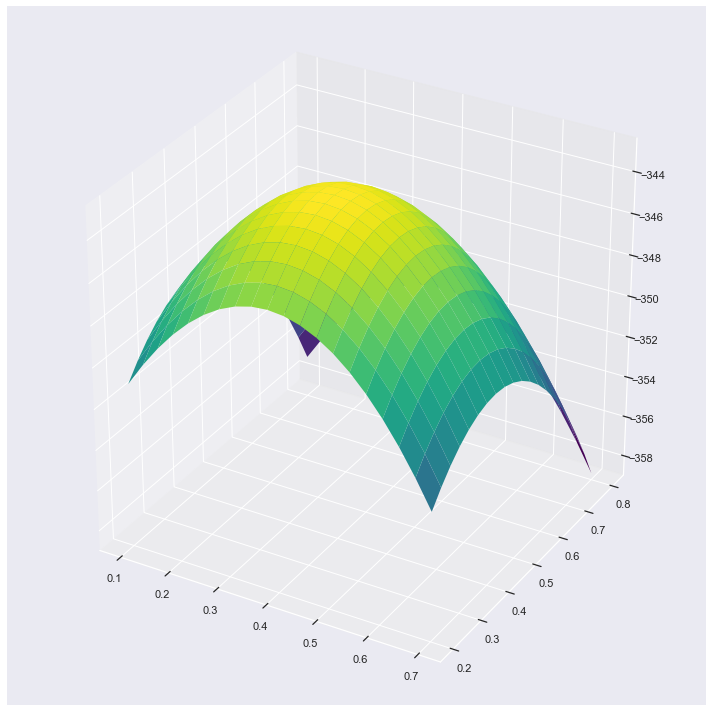

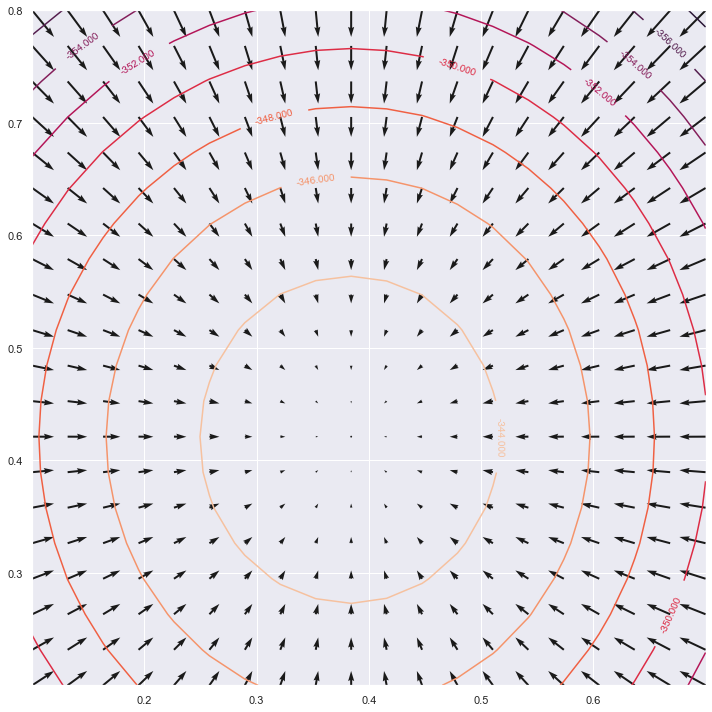

In [22]:
kf_res = []
kf_res_grad = []
eps = 1e-5

for val in tqdm.tqdm(mesh):
    a_val, b_val = val
    transition_matrix_np_a_eps = np.diag([a_val+eps, b_val])
    transition_matrix_np_b_eps = np.diag([a_val, b_val+eps])
    transition_matrix_np = np.diag([a_val, b_val])
    
    kf_a_eps = pykalman.KalmanFilter(transition_matrix_np_a_eps, 
                                     observation_matrix.numpy(), 
                                     transition_covariance.numpy(), 
                                     observation_covariance.numpy(), 
                                     initial_state_mean=[0., 0.], 
                                     initial_state_covariance=np.eye(2))
    
    kf_b_eps = pykalman.KalmanFilter(transition_matrix_np_b_eps, 
                                     observation_matrix.numpy(), 
                                     transition_covariance.numpy(), 
                                     observation_covariance.numpy(), 
                                     initial_state_mean=[0., 0.], 
                                     initial_state_covariance=np.eye(2))
    
    kf = pykalman.KalmanFilter(transition_matrix_np, 
                               observation_matrix.numpy(), 
                               transition_covariance.numpy(), 
                               observation_covariance.numpy(), 
                               initial_state_mean=[0., 0.], 
                               initial_state_covariance=np.eye(2))
    
    ll = kf.loglikelihood(np_obs)
    ll_a_eps = kf_a_eps.loglikelihood(np_obs)
    ll_b_eps = kf_b_eps.loglikelihood(np_obs)
    
    kf_res.append(ll)
    kf_res_grad.append([(ll_a_eps-ll)/eps, (ll_b_eps-ll)/eps])
kf_res = np.asanyarray(kf_res)
kf_res_grad = np.asanyarray(kf_res_grad)
plot_surface(kf_res, 'Kalman Filter', 'kalman', min_, max_)
plot_vector_field(kf_res, kf_res_grad, 'Kalman Filter', 'kalman')


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [15:36<00:00,  2.34s/it]


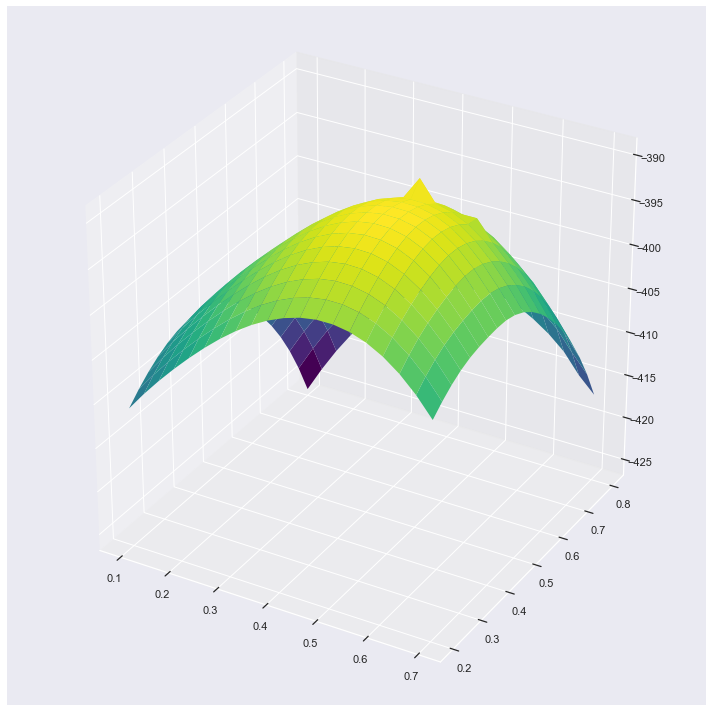

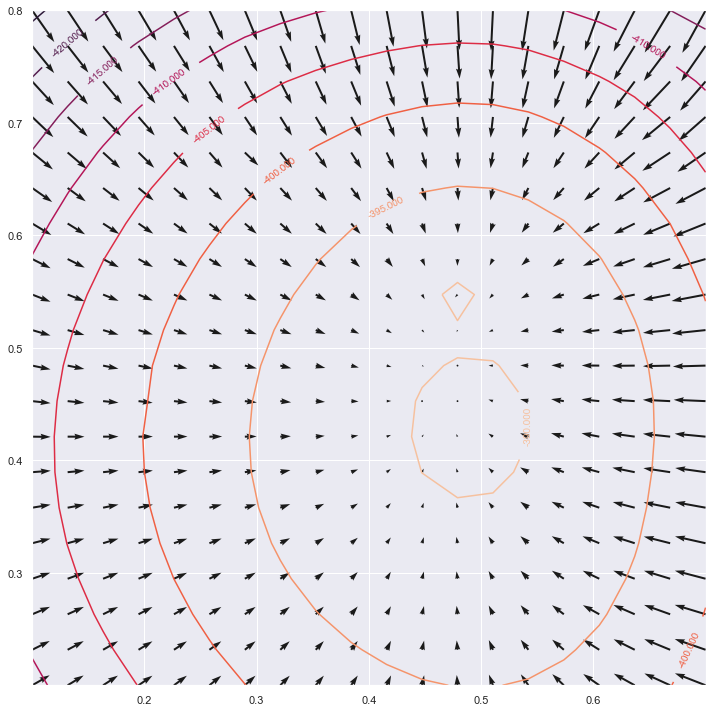

In [24]:
regularized_data = get_surface(mesh, regularized_smc, False).numpy()
plot_surface(regularized_data[:, 0], 'Regularized Resampling', 'regularized', min_, max_)
plot_vector_field(regularized_data[:, 0], regularized_data[:, 1:], 'Regularized Resampling', 'regularized')

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [16:17<00:00,  2.44s/it]


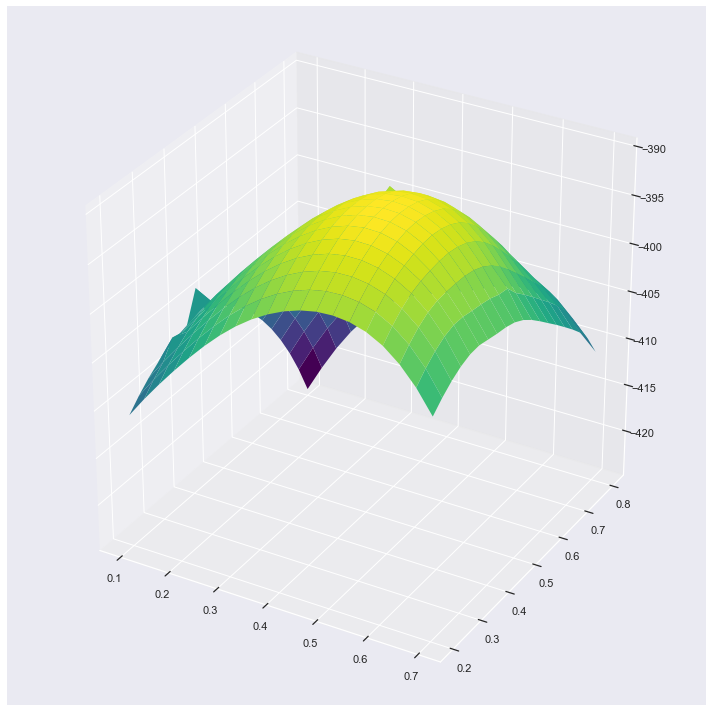

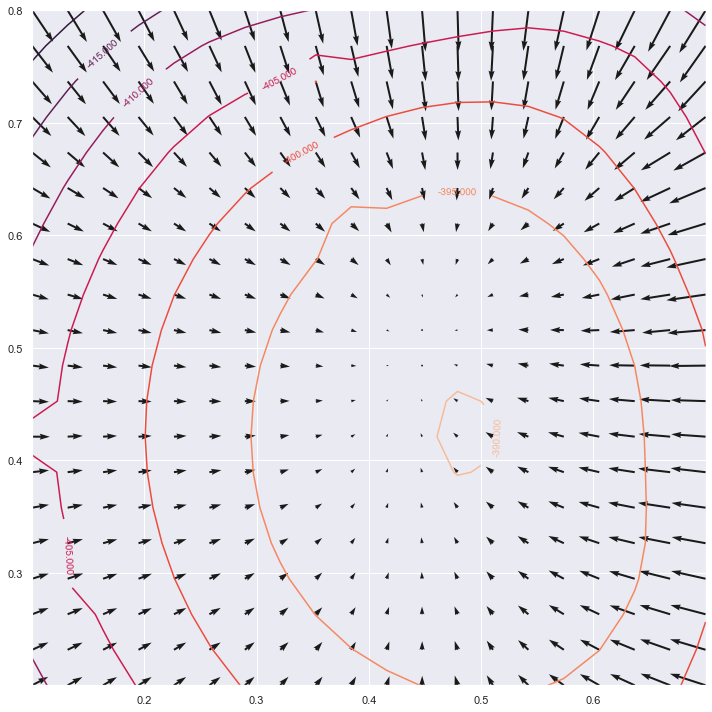

In [25]:
partially_corrected_data = get_surface(mesh, partially_corrected_smc, False).numpy()
plot_surface(partially_corrected_data[:, 0], 'Partially Corrected Regularized Resampling', 'partially_corrected_regularized', min_, max_)
plot_vector_field(partially_corrected_data[:, 0], partially_corrected_data[:, 1:], 'Partially Corrected Regularized Resampling', 'partially_corrected_regularized')

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [08:11<00:00,  1.23s/it]


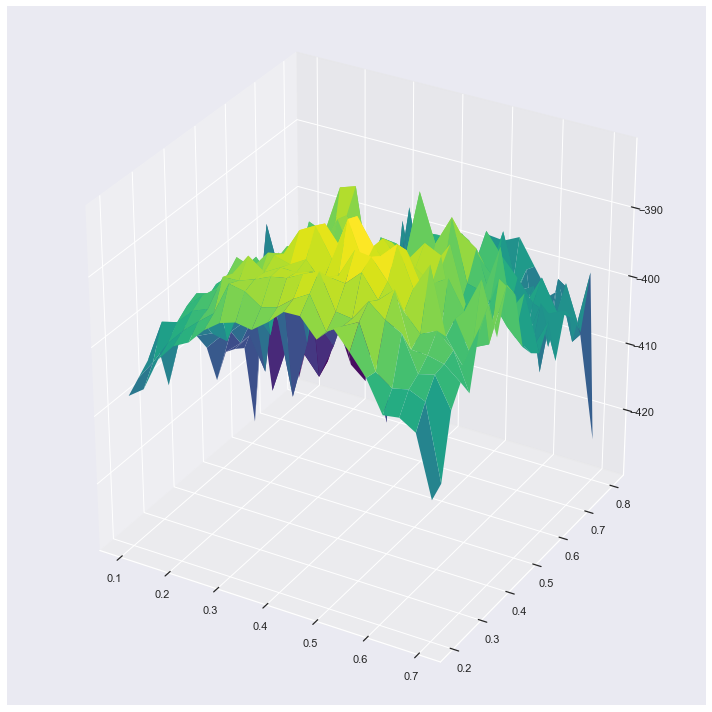

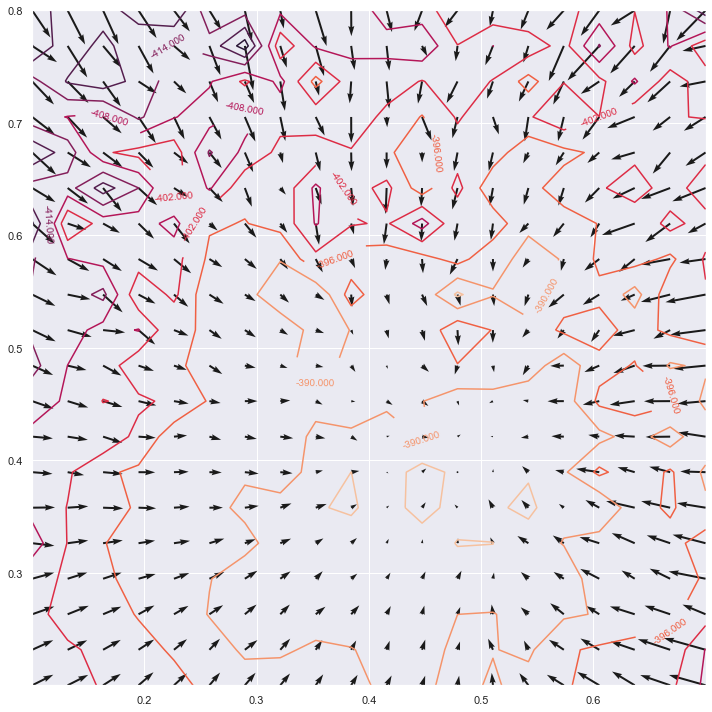

In [26]:
corrected_multinomial_data = get_surface(mesh, multinomial_smc, False).numpy()
plot_surface(corrected_multinomial_data[:, 0], 'Multinomial Resampling', 'multinomial_unbiased', min_, max_)
plot_vector_field(corrected_multinomial_data[:, 0], corrected_multinomial_data[:, 1:], 'Multinomial Resampling - Unbiased', 'multinomial_unbiased')

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [24:30<00:00,  3.68s/it]


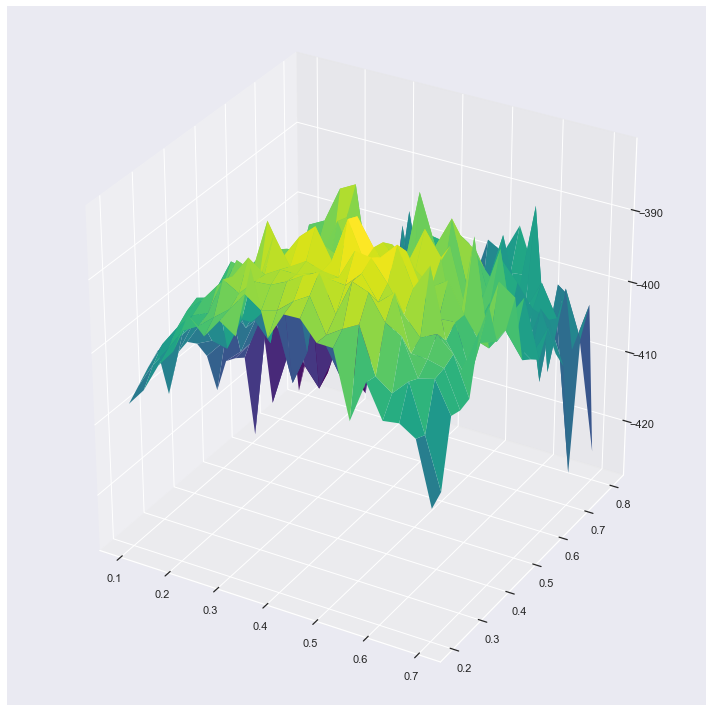

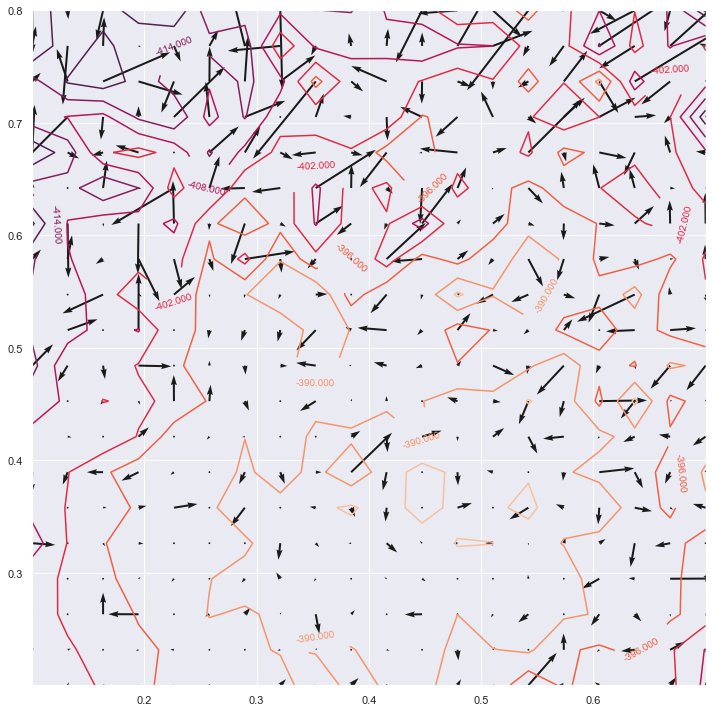

In [27]:
corrected_multinomial_data = get_surface_finite_diff(mesh, multinomial_smc, True).numpy()
plot_surface(corrected_multinomial_data[:, 0], 'Multinomial Resampling', 'multinomial_finite_diff', min_, max_)
plot_vector_field(corrected_multinomial_data[:, 0], corrected_multinomial_data[:, 1:], 'Multinomial Resampling - Finite Difference', 'multinomial_finite_diff')

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [08:10<00:00,  1.23s/it]


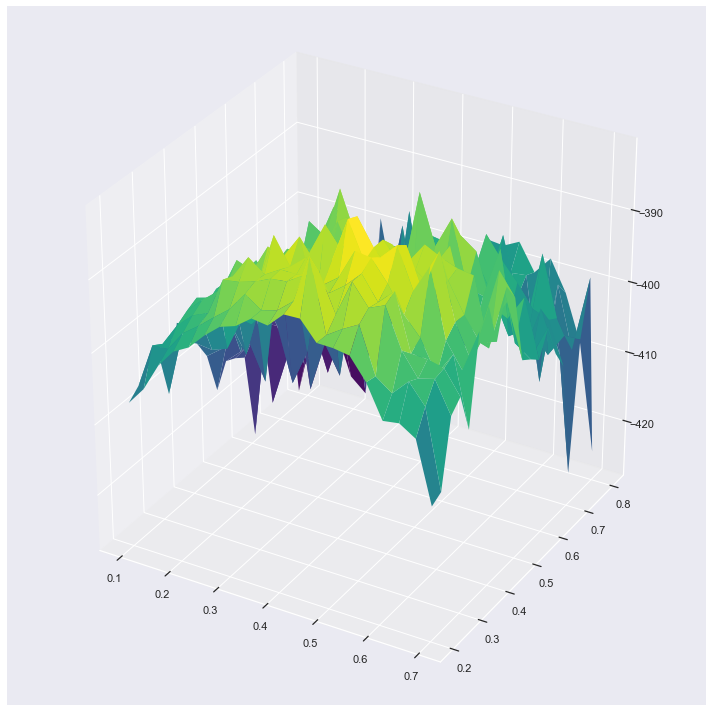

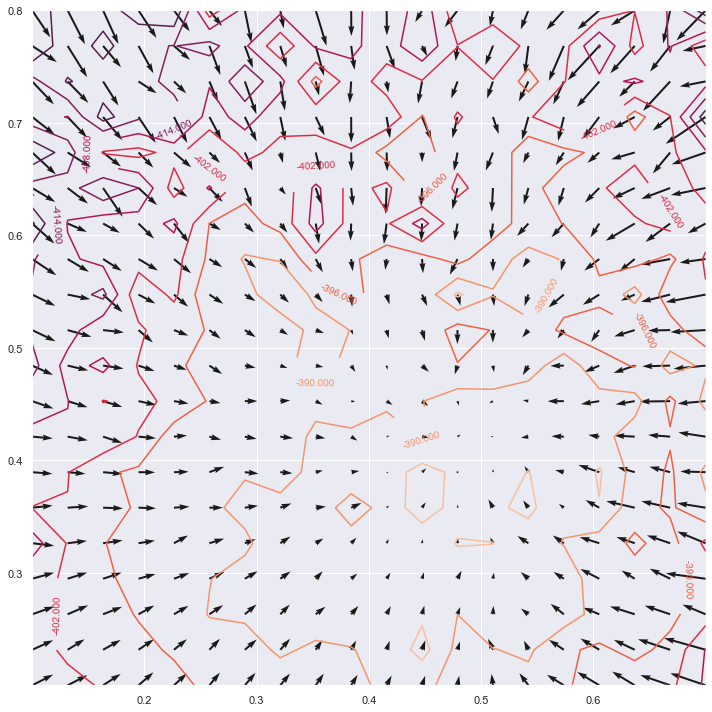

In [28]:
multinomial_data = get_surface(mesh, multinomial_smc, False).numpy()
plot_surface(multinomial_data[:, 0], 'Multinomial Resampling', 'multinomial_biased', min_, max_)
plot_vector_field(multinomial_data[:, 0], multinomial_data[:, 1:], 'Multinomial Resampling - Biased', 'multinomial_biased')

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [3:52:30<00:00, 34.88s/it]


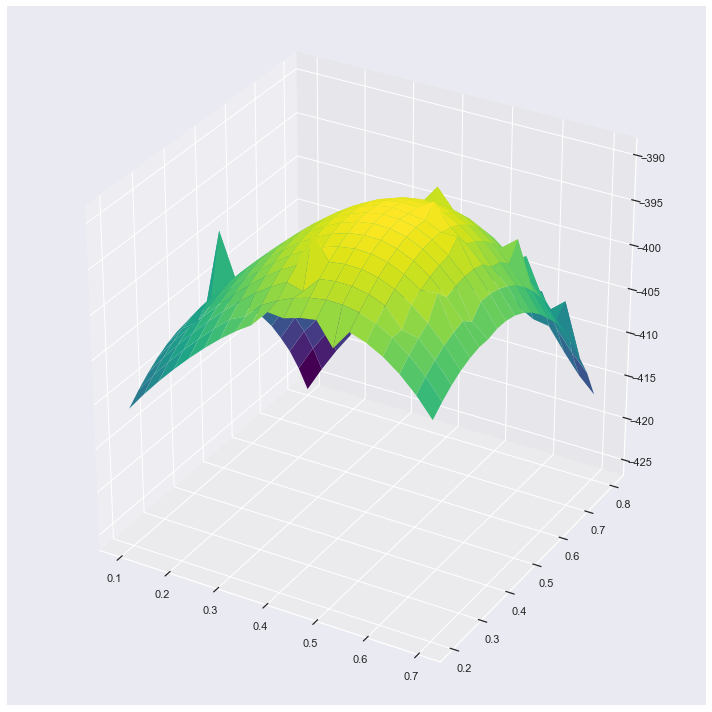

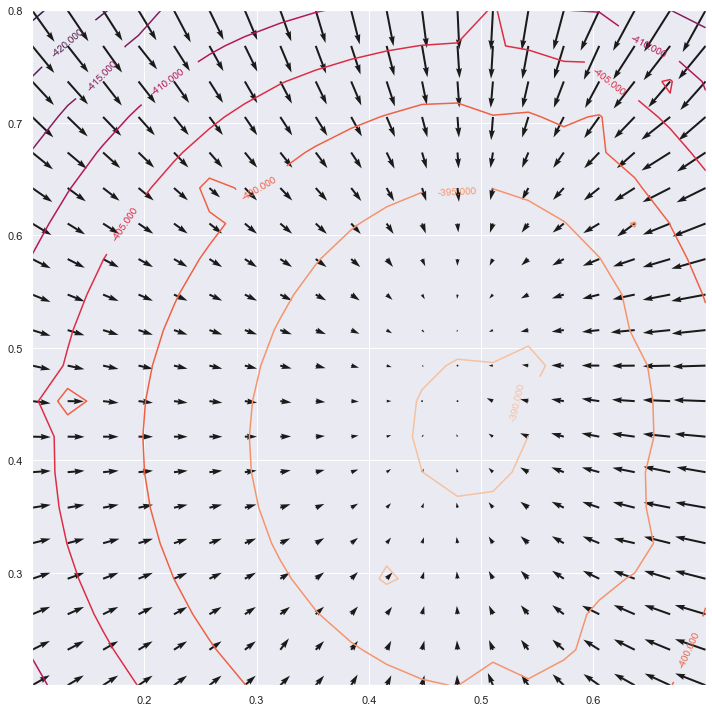

In [29]:
sinkhorn_optimized_data = get_surface(mesh, sinkhorn_optimized_smc, False).numpy()
plot_surface(sinkhorn_optimized_data[:, 0], 'Sinkhorn Optimized Resampling', 'sinkhorn_optimized', min_, max_)
plot_vector_field(sinkhorn_optimized_data[:, 0], sinkhorn_optimized_data[:, 1:], 'Corrected Regularized Resampling', 'sinkhorn_optimized')

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [1:57:08<00:00, 17.57s/it]


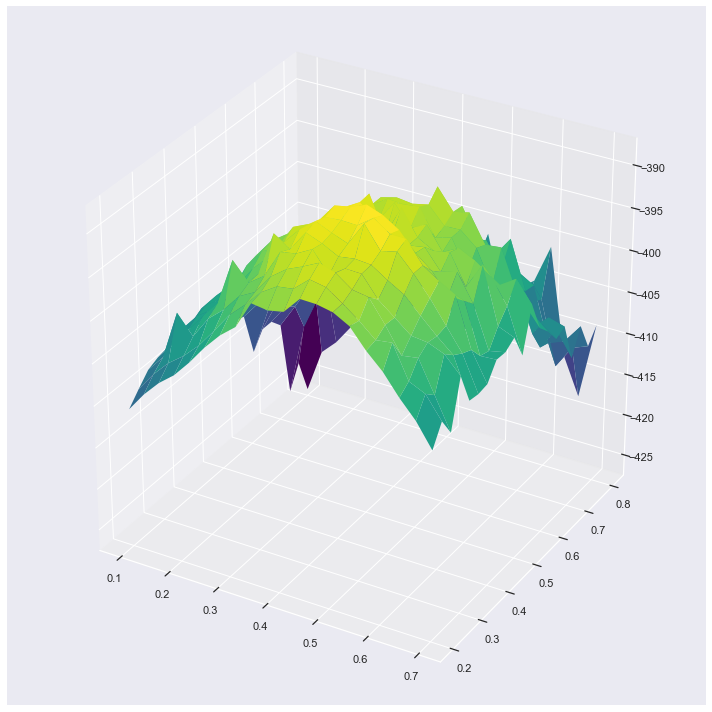

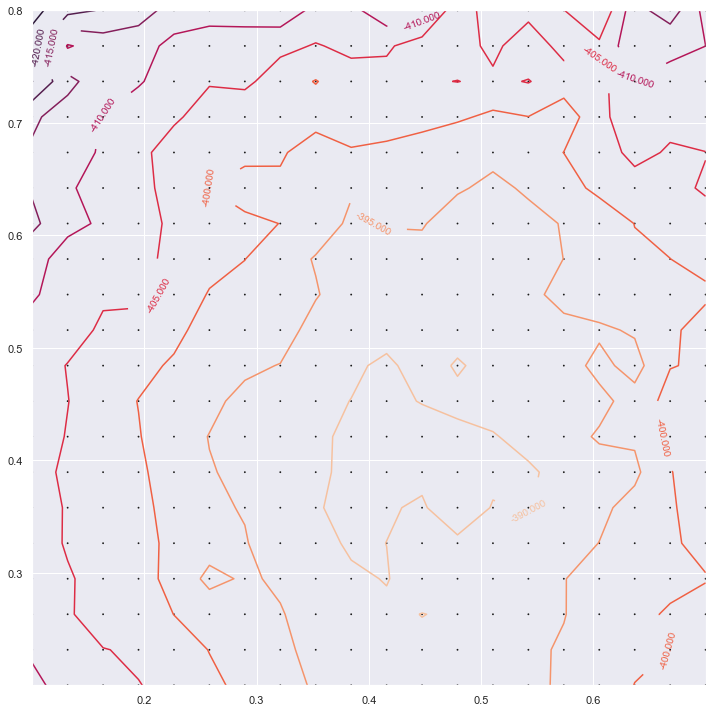

In [30]:
sliced_optimized_data = get_surface(mesh, sliced_optimized_smc, False).numpy()
plot_surface(sliced_optimized_data[:, 0], 'Sliced Optimized Resampling', 'sliced_optimized', min_, max_)
plot_vector_field(sliced_optimized_data[:, 0], sliced_optimized_data[:, 1:], 'Sliced Optimized Resampling', 'sliced_optimized')

  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [1:04:51<00:00,  9.73s/it]


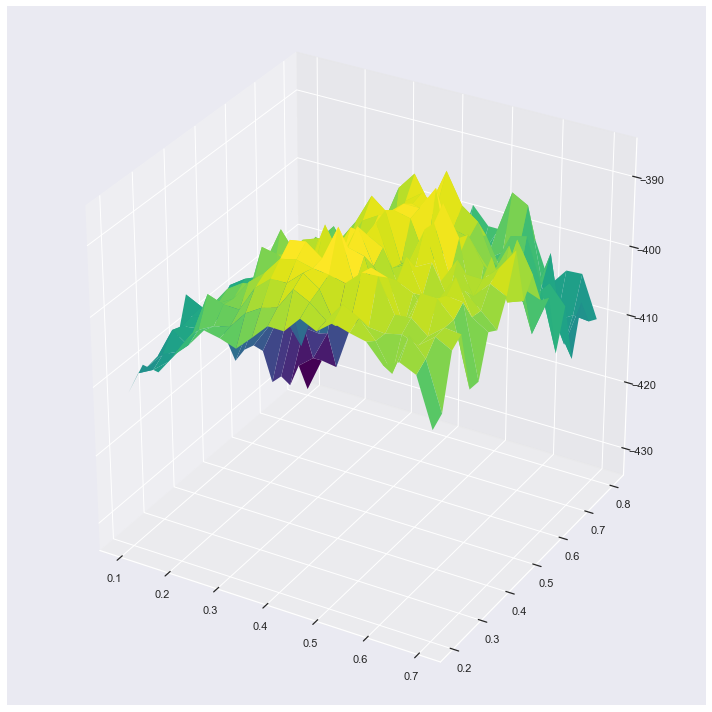

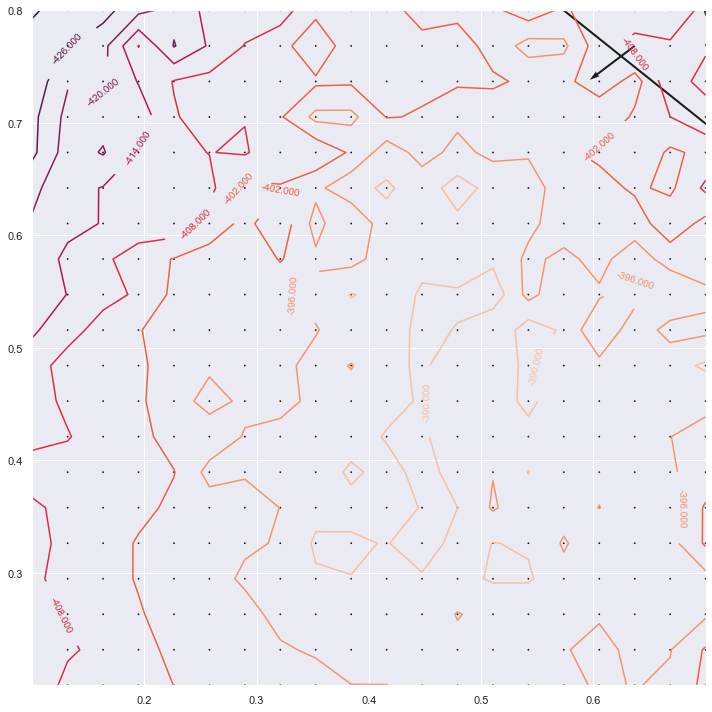

In [31]:
svd_data = get_surface(mesh, svd_smc, False).numpy()
plot_surface(svd_data[:, 0], 'SVD Resampling', 'svd', min_, max_)
plot_vector_field(svd_data[:, 0], svd_data[:, 1:], 'SVD Resampling', 'svd')

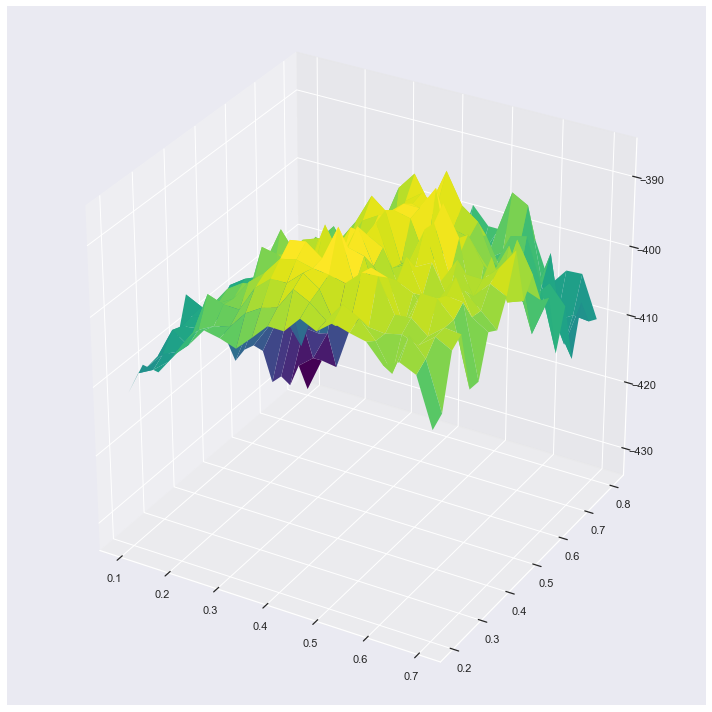

In [32]:
plot_surface(svd_data[:, 0], 'SVD Resampling', 'svd', min_, max_)


100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [1:06:19<00:00,  9.95s/it]


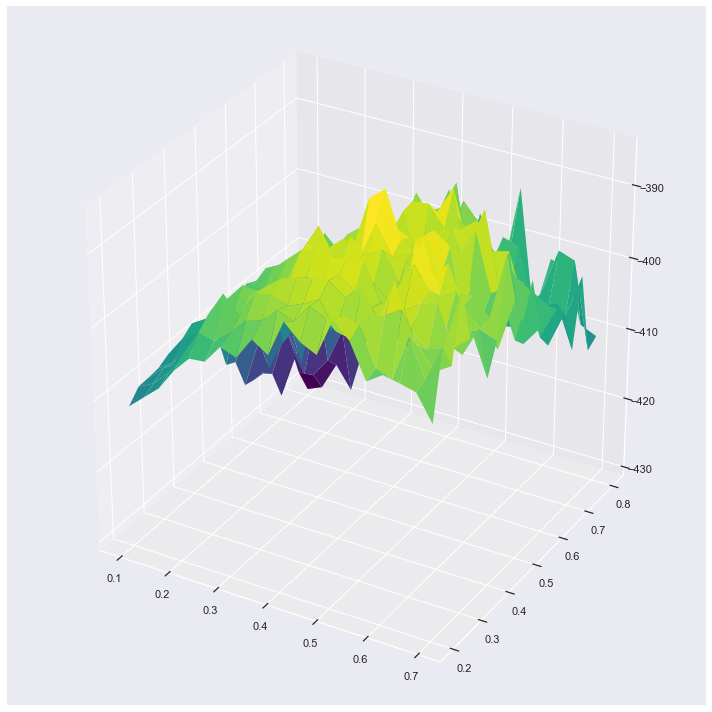

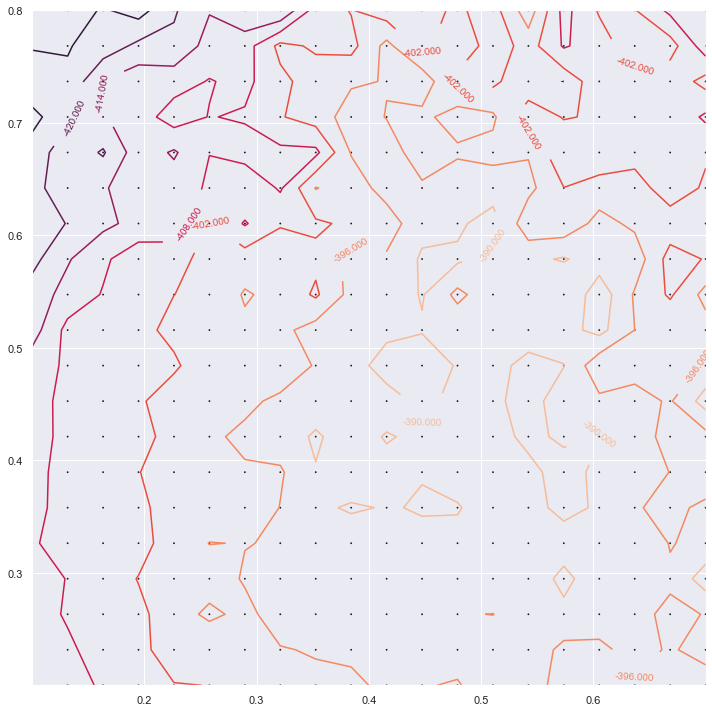

In [33]:
partially_corrected_svd_data = get_surface(mesh, partially_corrected_svd_smc, False).numpy()
plot_surface(partially_corrected_svd_data[:, 0], 'Partially Corrected SVD Resampling', 'corrected_svd', min_, max_)
plot_vector_field(partially_corrected_svd_data[:, 0], partially_corrected_svd_data[:, 1:], 'Partially Corrected SVD Resampling', 'corrected_svd')

In [ ]:
corrected_data = get_surface(mesh, corrected_smc, False).numpy()
plot_surface(corrected_data[:, 0], 'Corrected Regularized Resampling', 'corrected_regularized', min_, max_)
plot_vector_field(corrected_data[:, 0], corrected_data[:, 1:], 'Corrected Regularized Resampling', 'corrected_regularized')

  1%|▊                                                                                 | 4/400 [00:22<39:36,  6.00s/it]

In [ ]:
propagated_corrected_data = get_surface(mesh, propagated_corrected_smc, False).numpy()
plot_surface(propagated_corrected_data[:, 0], 'Propagated Corrected Regularized Resampling', 'propagated_corrected_regularized', min_, max_)
plot_vector_field(propagated_corrected_data[:, 0], propagated_corrected_data[:, 1:], 'Propagated Corrected Regularized Resampling', 'propagated_corrected_regularized')